# Import Section & Set Variables

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain
import matplotlib.pyplot as plt

%matplotlib inline

fname = "Apple.csv"
sel_region = "Sacramento"

WINDOWS = [15, 20, 25, 40]

---

# Preprocess Dataset

In [2]:
df_apple = pd.read_csv(fname)
df_apple.head(5)

,Date,Small size,Large,type,year,region
0,27/12/2015,1036.74,54454.85,conventional,2015,Albany
1,20/12/2015,674.28,44638.81,conventional,2015,Albany
2,13/12/2015,794.70,109149.67,conventional,2015,Albany
3,6/12/2015,1132.00,71976.41,conventional,2015,Albany
4,29/11/2015,941.48,43838.39,conventional,2015,Albany


In [3]:
#ตรวจสอบประเภทของข้อมูลแต่ละ column
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        18249 non-null  object 
 1   Small size  18249 non-null  float64
 2   Large       18249 non-null  float64
 3   type        18249 non-null  object 
 4   year        18249 non-null  int64  
 5   region      18249 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 855.5+ KB


In [4]:
#ทำการเปลี่ยน Date ให้อยู่ในประเภทของ datetime เพื่อทำการ sort
df_apple['Date'] = pd.to_datetime(df_apple['Date'], format="%d/%m/%Y")

#sort ข้อมูลตามวันที่โดยเรียงจากอดีตไปปัจจุบัน
df_apple = df_apple.sort_values("Date")
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 11569 to 8814
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        18249 non-null  datetime64[ns]
 1   Small size  18249 non-null  float64       
 2   Large       18249 non-null  float64       
 3   type        18249 non-null  object        
 4   year        18249 non-null  int64         
 5   region      18249 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 998.0+ KB


In [5]:
df_apple.head(1)

,Date,Small size,Large,type,year,region
11569,2015-01-04,9307.34,3844.81,organic,2015,Southeast


In [6]:
#ทำการปรับ format ของ Date ให้อยู่ในรูปของ d/m/y
df_apple["Date"] = df_apple["Date"].dt.strftime('%d/%m/%Y')
df_apple.head(1)

,Date,Small size,Large,type,year,region
11569,04/01/2015,9307.34,3844.81,organic,2015,Southeast


## Split Data Into Two Categories: "conventional" and "organic"

In [7]:
#ดึงข้อมูล apple ใน region ที่ดราต้องการ
df_apple_sacreamento = df_apple[df_apple["region"] == sel_region]
df_apple_sacreamento = df_apple_sacreamento.rename(columns={'Small size': 'Small'})

#แบ่งข้อมูลตามประเภทขนาดของ apple 
df_conventional = df_apple_sacreamento[df_apple_sacreamento["type"] == "conventional"]
df_organic = df_apple_sacreamento[df_apple_sacreamento["type"] == "organic"]

In [8]:
print("conventional :",len(df_conventional))
df_conventional.head()

conventional : 169


,Date,Small,Large,type,year,region
2131,04/01/2015,110693.69,270107.61,conventional,2015,Sacramento
2130,11/01/2015,109368.41,271300.08,conventional,2015,Sacramento
2129,18/01/2015,83097.77,238956.51,conventional,2015,Sacramento
2128,25/01/2015,101289.29,210411.75,conventional,2015,Sacramento
2127,01/02/2015,287292.15,429601.75,conventional,2015,Sacramento


In [9]:
print("organic :",len(df_organic))
df_organic.head()

organic : 169


,Date,Small,Large,type,year,region
11257,04/01/2015,3727.52,4327.52,organic,2015,Sacramento
11256,11/01/2015,4243.14,3033.84,organic,2015,Sacramento
11255,18/01/2015,15363.18,20986.36,organic,2015,Sacramento
11254,25/01/2015,4291.23,4741.77,organic,2015,Sacramento
11253,01/02/2015,7103.90,5624.41,organic,2015,Sacramento


---

# Function Definitions

## Remove Unused Columns (For Visualization)

In [10]:
#ลบ columns ที่ไม่ต้องการ
def remove_unused_col(df_data: pd.DataFrame):
    df_new = df_data.copy()
    df_new = df_new.drop(["type", "year", "region"], axis=1)
    return df_new

## Define Window Size

In [11]:
#สร้าง dataframe ของ data ที่ทำการ window_size
##สมมติ ให้ size = 3
##จะทำการสร้าง x_1 x_2 y_0 y_1 y_2
def create_window(size: int, df_data: pd.DataFrame, feature_name: str) -> pd.DataFrame:
    df_window = df_data.copy()
    
    x = 1
    while x < size:
        df_window[f'x_{x}'] = df_window[feature_name].shift(-x)
        x = x + 1

    y = 0
    while y < size:
        df_window[f'y_{y}'] = df_window[feature_name].shift(-size-y)
        y= y + 1
        
    df_window = df_window.dropna(axis=0)
    
    return df_window


In [12]:
#สร้าง dataframe ตามขนาดของ window_size แล้ว return เป็น list ของ dataframe
#โดยในแต่ละ dataframe นั้นจะอิงตามขนาดของ window_size ที่อยู่ใน list
def get_windows_sequence(df_data: pd.DataFrame, feature_name: str, window_size: list):
    df_window_ls = list()
    for size in window_size:
            df_window_ls.append(create_window(size, df_data, feature_name))
    return df_window_ls

In [13]:
#สร้าง dataframe ของ data ที่ทำการ window_size
##สมมติ ให้ size = 3
##จะทำการสร้าง x_1 x_2 y_0
def create_window_one_predict(windows_length: int, df_data: pd.DataFrame, feature_name: str) -> pd.DataFrame:
    df_window = df_data.copy()
    x = 1
    while x < windows_length:
        df_window[f'x_{x}'] = df_window[feature_name].shift(-x)
        x = x + 1
    
    if x == windows_length:
        df_window['y'] = df_window[feature_name].shift(-x)
        
    df_window = df_window.dropna(axis=0)
    
    return df_window
        

In [14]:
#สร้าง dataframe ตามขนาดของ window_size แล้ว return เป็น list ของ dataframe
#โดยในแต่ละ dataframe นั้นจะอิงตามขนาดของ window_size ที่อยู่ใน list
def get_windows_sequence_one_predict(df_data: pd.DataFrame, feature_name: str, window_size: list):
    df_window_ls = list()
    for size in window_size:
            df_window_ls.append(create_window_one_predict(size, df_data, feature_name))
    return df_window_ls

## Split Train, Validation, and Test Set

In [15]:
#แบ่งข้อมูล train test โดยการตัดแบ่ง
def train_test_split(df: pd.DataFrame, feature: str,train_size):
    X_cols = [col for col in df.columns if col.startswith('x')]
    X_cols.insert(0, feature)

    y_cols = [col for col in df.columns if col.startswith('y')]

    X = df[X_cols].values
    y = df[y_cols].values

    return sklearn.model_selection.train_test_split(X, y, train_size=train_size, shuffle=False)

## Mean Absolute Percentage Error (MAPE) Function Definition

In [16]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

## Visualisation

In [17]:
def plot_bar(bp_mape, dt_mape, rc_mape):
    fig, ax = plt.subplots()

    x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
    y = [bp_mape, dt_mape, rc_mape]

    ax.bar(x, y, width=0.4, color=["violet", "orange", "green"])
    ax.set_xlabel('Regressor models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, int(max(y)) + 10)

    for index, value in enumerate(y):
        plt.text(x=index, y=value + 0.3, s=str(value), ha='center')
        
    plt.tight_layout()

In [18]:
def plot_line_graph(X_test, y_test, bp_model_preds, dt_model_preds, rc_model_preds):
    fig, ax = plt.subplots(figsize=(11,6))

    ax.plot(np.arange(0, X_test[1].shape[0], 1), X_test[1], marker="o", color="blue", label='Input')
    ax.plot(np.arange(X_test[1].shape[0], X_test[1].shape[0] + y_test[1].shape[0], 1), y_test[1], marker='.', color='blue', label='Actual')

    ax.plot(np.arange(X_test[1].shape[0], X_test[1].shape[0] + y_test[1].shape[0], 1), bp_model_preds[1], marker='.', color='violet', label= 'Baseline')
    ax.plot(np.arange(X_test[1].shape[0], X_test[1].shape[0] + y_test[1].shape[0], 1), dt_model_preds[1], marker='.', color='orange', label='Decision Tree')
    ax.plot(np.arange(X_test[1].shape[0], X_test[1].shape[0] + y_test[1].shape[0], 1), rc_model_preds[1], marker='.', color='green', label='Gradient Boosting')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Consumption Amount')

    plt.xticks(np.arange(0, X_test[1].shape[0] + y_test[1].shape[0]), df_conventional["Date"][-(X_test[1].shape[0] + y_test[1].shape[0]):])
    plt.legend(loc=2)

    fig.autofmt_xdate()
    plt.tight_layout()

In [19]:
def plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, windows: list):
        X = windows
        X_axis = np.arange(len(X))

        fig,ax = plt.subplots()

        plt.bar(X_axis - 0.2, bp_mapes, 0.2, label = 'Baseline Prediction', color="teal")
        plt.bar(X_axis + 0, dt_mapes, 0.2, label = 'Decision Tree', color="orange")
        plt.bar(X_axis + 0.2, rc_mapes, 0.2, label = 'Gradient Boosting', color="green")
        
        max_y = max([max(ls) for ls in [bp_mapes,dt_mapes,rc_mapes]])
        
        ax.set_ylim(0, max_y+10)
        
        for index, value in enumerate(bp_mapes):
                plt.text(x=index - 0.2, y=value + 1, s=str(value), ha='center', size=7)
        for index, value in enumerate(dt_mapes):
                plt.text(x=index + 0, y=value + 2, s=str(value), ha='center', size=7)
        for index, value in enumerate(rc_mapes):
                plt.text(x=index + 0.2, y=value + 1, s=str(value), ha='center', size=7)

        plt.xticks(X_axis, X)
        plt.xlabel("Windows Size")
        plt.ylabel("MAPE (%)")
        plt.title("MAPE in Percentage for Each Window Size")
        plt.legend()
        plt.show()

---

## Model Fitting

### Baseline Prediction

In [20]:
def bp_calc(X_test, y_test):
    bp_mape = mape(y_test.reshape(1, -1), X_test.reshape(1, -1))
    return (X_test, bp_mape)

In [21]:
def bp_calc_seq_input(X_test, y_test):
    bp_model_preds = []
    
    for row in X_test:
        bp_model_preds.append(np.mean(row))
    return (bp_model_preds, mape(y_test, bp_model_preds))

### Decision Tree Regressor

In [22]:
def dt_calc(X_train, y_train, X_test, y_test):
    dt_model = DecisionTreeRegressor()
    dt_model.fit(X_train, y_train)
    dt_model_preds = dt_model.predict(X_test)
    dt_mape = mape(y_test.reshape(1, -1), dt_model_preds.reshape(1, -1))
    return (dt_model_preds, dt_mape)

### Gradient Boosting

In [23]:
def rc_calc(X_train, y_train, X_test, y_test):
    gb_model = GradientBoostingRegressor()
    rc_model = RegressorChain(gb_model)
    rc_model.fit(X_train, y_train)
    rc_model_preds = rc_model.predict(X_test)
    rc_mape = mape(y_test.reshape(1, -1), rc_model_preds.reshape(1, -1))
    return (rc_model_preds, rc_mape)

---

# "Conventional" Apple Type

## "Small" Apple

### One Past Predicts One Future

In [24]:
df_conventional = remove_unused_col(df_conventional)

df_list = get_windows_sequence(df_conventional, "Small", [1])

In [25]:
df_list[0].head()

,Date,Small,Large,y_0
2131,04/01/2015,110693.69,270107.61,109368.41
2130,11/01/2015,109368.41,271300.08,83097.77
2129,18/01/2015,83097.77,238956.51,101289.29
2128,25/01/2015,101289.29,210411.75,287292.15
2127,01/02/2015,287292.15,429601.75,144586.53


In [26]:
X_trains = []
y_trains = []
X_tests = []
y_tests = []

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small",0.8)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [27]:
bp_preds = []
bp_mapes = []

dt_preds = []
dt_mapes = []

rc_preds = []
rc_mapes = []

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

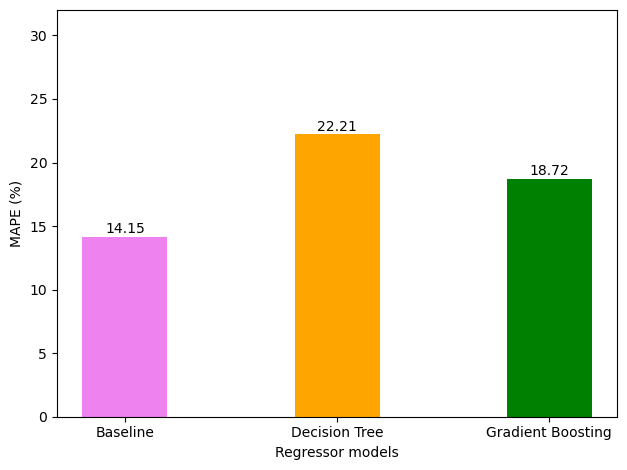

In [28]:
plot_bar(bp_mapes[1-1], dt_mapes[1-1], rc_mapes[1-1])

### Sequence of Pasts Predicts One Future

In [29]:
df_list = get_windows_sequence_one_predict(df_conventional, "Small", WINDOWS)

In [30]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small",0.8)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [31]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc_seq_input(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

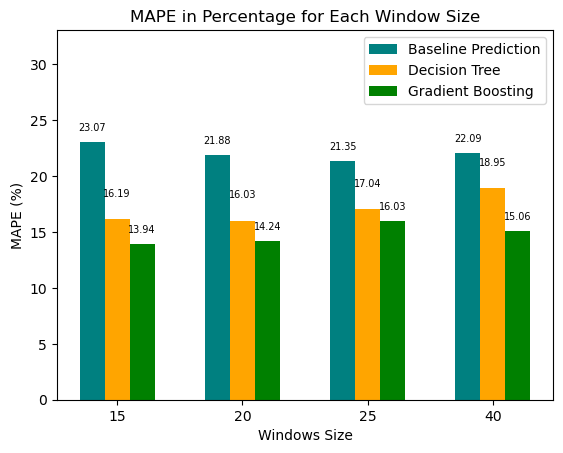

In [32]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

### Sequence of Pasts Predicts Sequence of Futures

In [33]:
df_list = get_windows_sequence(df_conventional, "Small", WINDOWS)

In [34]:
s_c_X_trains = list()
s_c_y_trains = list()
s_c_X_tests = list()
s_c_y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small",0.8)
    s_c_X_trains.append(X_train)
    s_c_y_trains.append(y_train)
    s_c_X_tests.append(X_test)
    s_c_y_tests.append(y_test)


In [35]:
s_c_bp_preds = list()
s_c_bp_mapes = list()

s_c_dt_preds = list()
s_c_dt_mapes = list()

s_c_rc_preds = list()
s_c_rc_mapes = list()

for i, v in enumerate(s_c_X_trains):
    bp = bp_calc(s_c_X_tests[i], s_c_y_tests[i])
    dt = dt_calc(s_c_X_trains[i], s_c_y_trains[i], s_c_X_tests[i], s_c_y_tests[i])
    rc = rc_calc(s_c_X_trains[i], s_c_y_trains[i], s_c_X_tests[i], s_c_y_tests[i])
    s_c_bp_preds.append(bp[0])
    s_c_bp_mapes.append(bp[1])
    s_c_dt_preds.append(dt[0])
    s_c_dt_mapes.append(dt[1])
    s_c_rc_preds.append(rc[0])
    s_c_rc_mapes.append(rc[1])
    

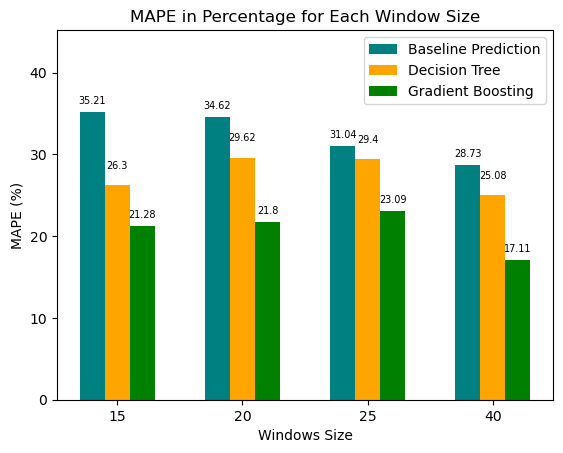

In [36]:
plot_mape_comparison(s_c_bp_mapes, s_c_dt_mapes, s_c_rc_mapes, WINDOWS)

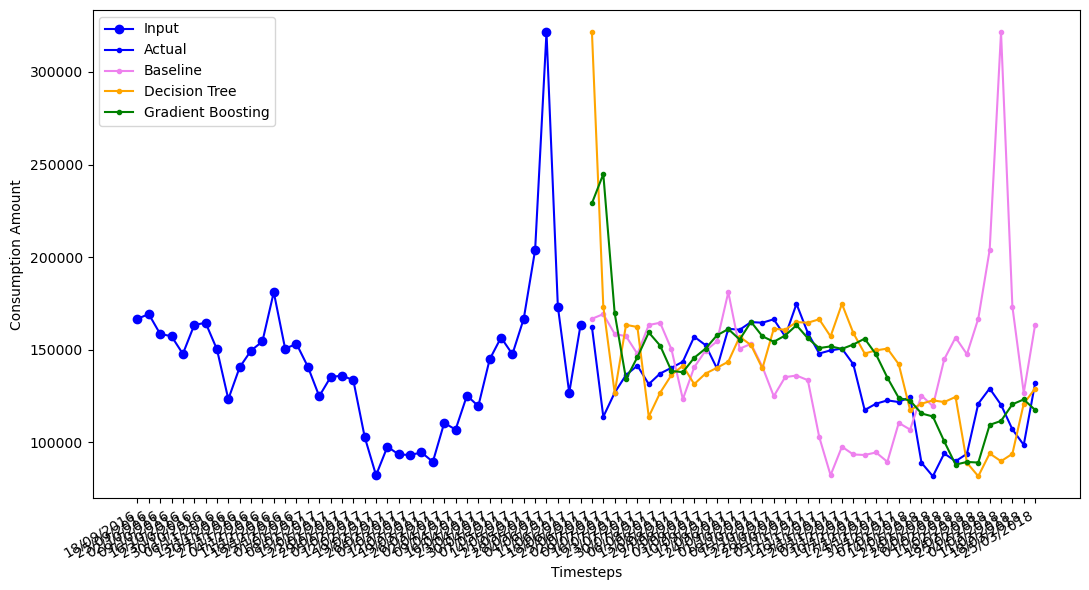

In [37]:
#สามารถใช้ค่า i เพื่อดูกราฟในแต่ละ window_size ; [15, 20, 25, 40]
i = 3
plot_line_graph(s_c_X_tests[i], s_c_y_tests[i], s_c_bp_preds[i], s_c_dt_preds[i], s_c_rc_preds[i])

---

## "Large" Apple

### One Past Predicts One Future

In [38]:
df_list = get_windows_sequence(df_conventional, "Large", [1])

In [39]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large", 0.8)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [40]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

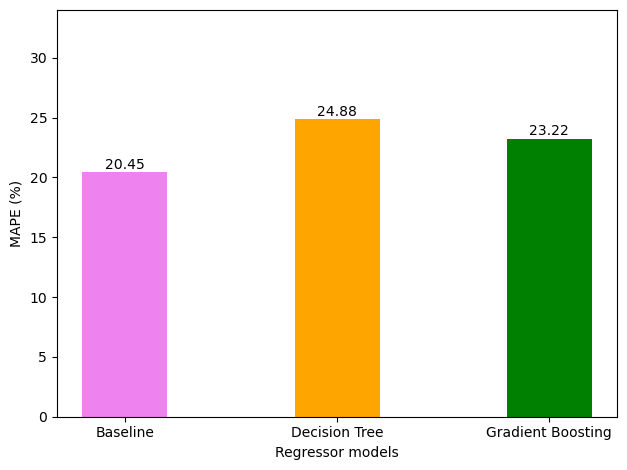

In [41]:
plot_bar(bp_mapes[1-1], dt_mapes[1-1], rc_mapes[1-1])

### Sequence of Pasts Predicts One Future

In [42]:
df_list = get_windows_sequence_one_predict(df_conventional, "Large", WINDOWS)

In [43]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large",0.8)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [44]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc_seq_input(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

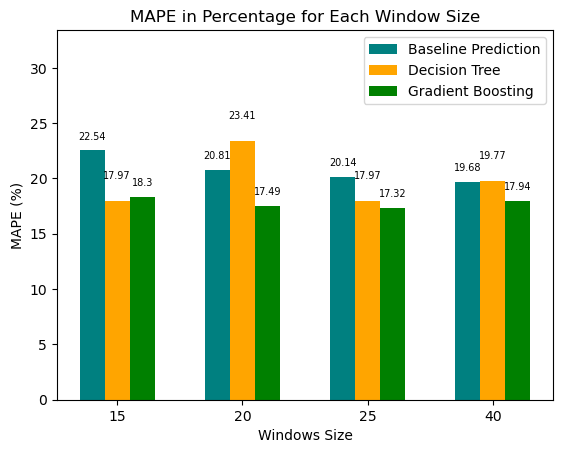

In [45]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

### Sequence of Pasts Predicts Sequence of Futures

In [46]:
df_list = get_windows_sequence(df_conventional, "Large", WINDOWS)

In [47]:
l_c_X_trains = list()
l_c_y_trains = list()
l_c_X_tests = list()
l_c_y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large",0.8)
    l_c_X_trains.append(X_train)
    l_c_y_trains.append(y_train)
    l_c_X_tests.append(X_test)
    l_c_y_tests.append(y_test)


In [48]:
l_c_bp_preds = list()
l_c_bp_mapes = list()

l_c_dt_preds = list()
l_c_dt_mapes = list()

l_c_rc_preds = list()
l_c_rc_mapes = list()

for i, v in enumerate(l_c_X_trains):
    bp = bp_calc(l_c_X_tests[i], l_c_y_tests[i])
    dt = dt_calc(l_c_X_trains[i], l_c_y_trains[i], l_c_X_tests[i], l_c_y_tests[i])
    rc = rc_calc(l_c_X_trains[i], l_c_y_trains[i], l_c_X_tests[i], l_c_y_tests[i])
    l_c_bp_preds.append(bp[0])
    l_c_bp_mapes.append(bp[1])
    l_c_dt_preds.append(dt[0])
    l_c_dt_mapes.append(dt[1])
    l_c_rc_preds.append(rc[0])
    l_c_rc_mapes.append(rc[1])
    

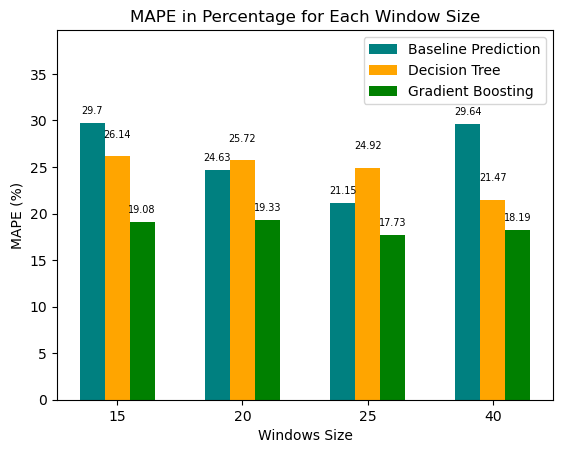

In [49]:
plot_mape_comparison(l_c_bp_mapes, l_c_dt_mapes, l_c_rc_mapes, WINDOWS)

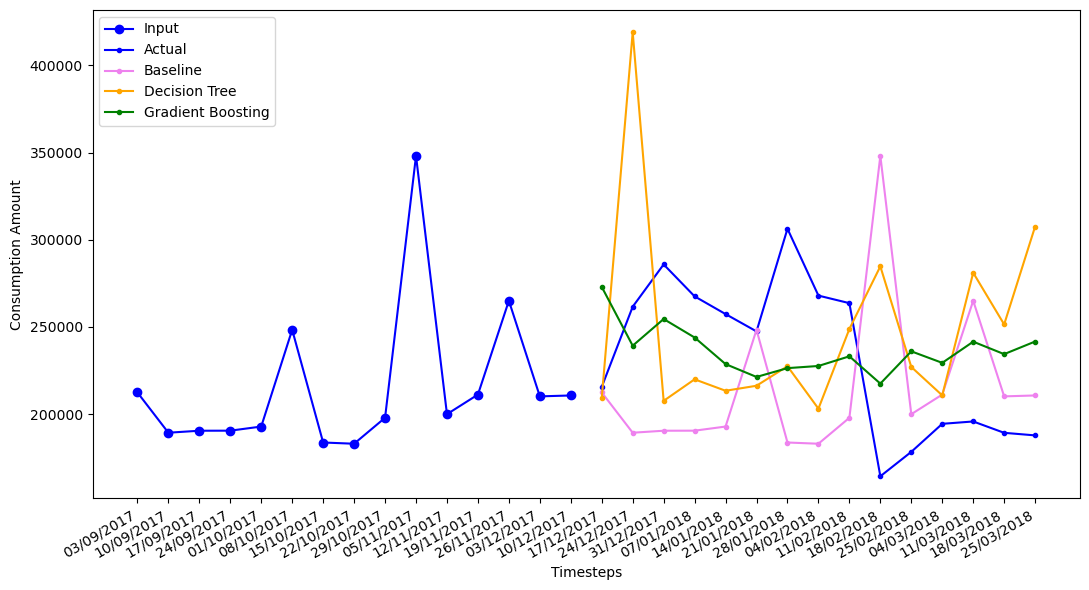

In [50]:
#สามารถใช้ค่า i เพื่อดูกราฟในแต่ละ window_size ; [15, 20, 25, 40]
i = 0
plot_line_graph(l_c_X_tests[i], l_c_y_tests[i], l_c_bp_preds[i], l_c_dt_preds[i], l_c_rc_preds[i])

---

# "Organic" Apple Type

In [51]:
df_organic = remove_unused_col(df_organic)
df_organic

,Date,Small,Large
11257,04/01/2015,3727.52,4327.52
11256,11/01/2015,4243.14,3033.84
11255,18/01/2015,15363.18,20986.36
11254,25/01/2015,4291.23,4741.77
11253,01/02/2015,7103.90,5624.41
...,...,...,...
18085,25/02/2018,2169.03,4285.39
18084,04/03/2018,2391.35,3880.13
18083,11/03/2018,2317.50,3561.20
18082,18/03/2018,1954.32,3597.70


## "Small" Apple

### One Past Predicts One Future

In [52]:
df_list = get_windows_sequence(df_organic, "Small", [1])

In [53]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small",0.8)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [54]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

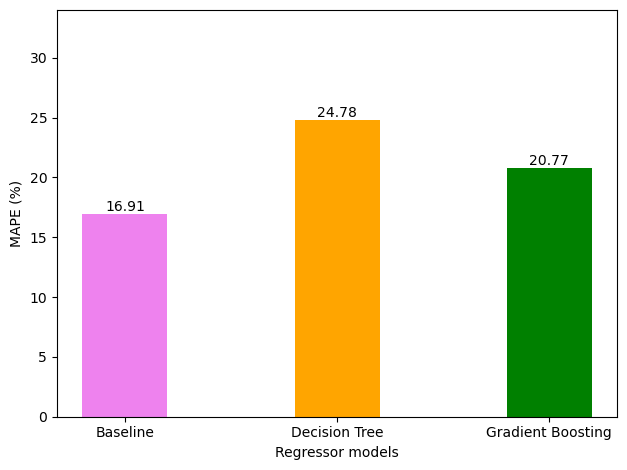

In [55]:
plot_bar(bp_mapes[1-1], dt_mapes[1-1], rc_mapes[1-1])

### Sequence of Pasts Predicts One Future

In [56]:
df_list = get_windows_sequence_one_predict(df_organic, "Small", WINDOWS)

In [57]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small",0.8)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [58]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc_seq_input(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

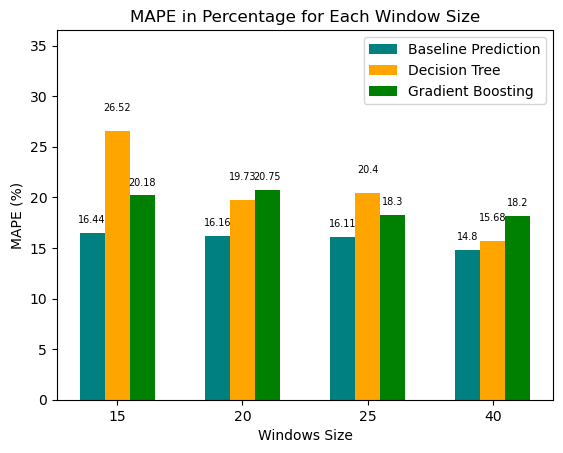

In [59]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

### Sequence of Pasts Predicts Sequence of Futures

In [60]:
df_list = get_windows_sequence(df_organic, "Small", WINDOWS)

In [61]:
s_o_X_trains = list()
s_o_y_trains = list()
s_o_X_tests = list()
s_o_y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small",0.8)
    s_o_X_trains.append(X_train)
    s_o_y_trains.append(y_train)
    s_o_X_tests.append(X_test)
    s_o_y_tests.append(y_test)


In [62]:
s_o_bp_preds = list()
s_o_bp_mapes = list()

s_o_dt_preds = list()
s_o_dt_mapes = list()

s_o_rc_preds = list()
s_o_rc_mapes = list()

for i, v in enumerate(s_o_X_trains):
    bp = bp_calc(s_o_X_tests[i], s_o_y_tests[i])
    dt = dt_calc(s_o_X_trains[i], s_o_y_trains[i], s_o_X_tests[i], s_o_y_tests[i])
    rc = rc_calc(s_o_X_trains[i], s_o_y_trains[i], s_o_X_tests[i], s_o_y_tests[i])
    s_o_bp_preds.append(bp[0])
    s_o_bp_mapes.append(bp[1])
    s_o_dt_preds.append(dt[0])
    s_o_dt_mapes.append(dt[1])
    s_o_rc_preds.append(rc[0])
    s_o_rc_mapes.append(rc[1])
    

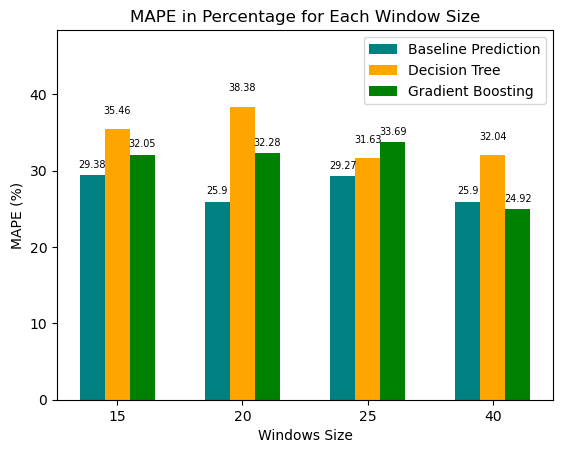

In [63]:
plot_mape_comparison(s_o_bp_mapes, s_o_dt_mapes, s_o_rc_mapes, WINDOWS)

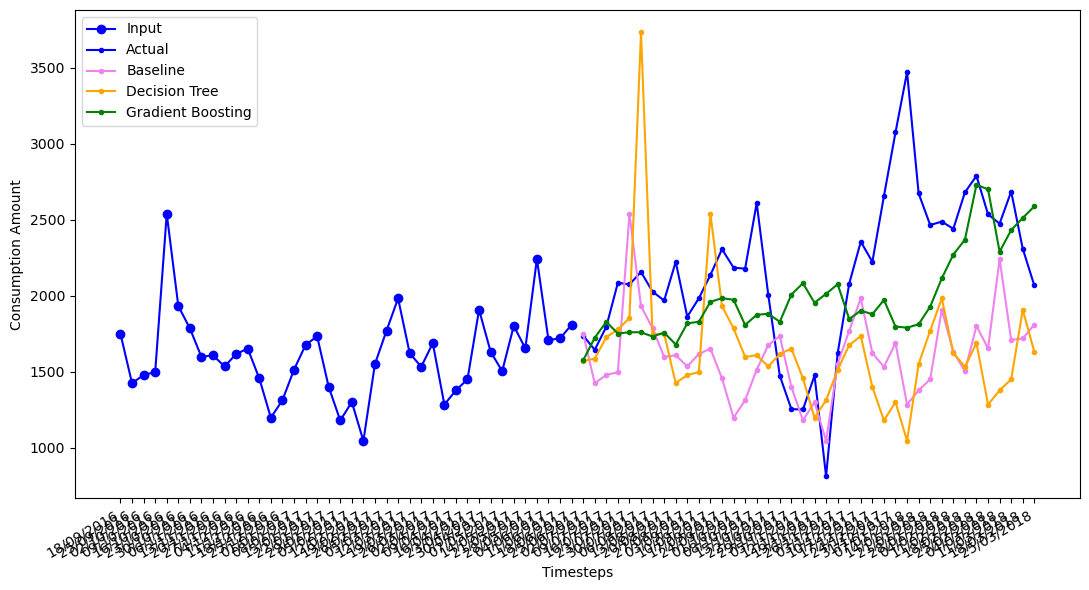

In [64]:
#สามารถใช้ค่า i เพื่อดูกราฟในแต่ละ window_size ; [15, 20, 25, 40]
i = 3
plot_line_graph(s_o_X_tests[i], s_o_y_tests[i], s_o_bp_preds[i], s_o_dt_preds[i], s_o_rc_preds[i])

---

## "Large" Apple

### One Past Predicts One Future

In [65]:
df_list = get_windows_sequence(df_organic, "Large", [1])

In [66]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large",0.8)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [67]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

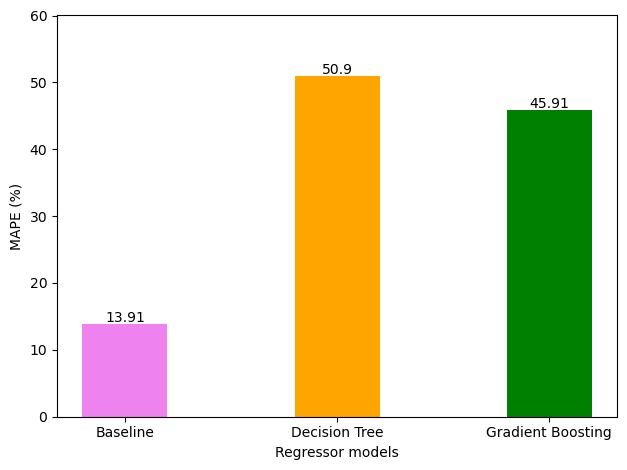

In [68]:
plot_bar(bp_mapes[1-1], dt_mapes[1-1], rc_mapes[1-1])

### Sequence of Pasts Predicts One Future

In [69]:
df_list = get_windows_sequence_one_predict(df_organic, "Large", WINDOWS)

In [70]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large",0.8)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [71]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc_seq_input(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

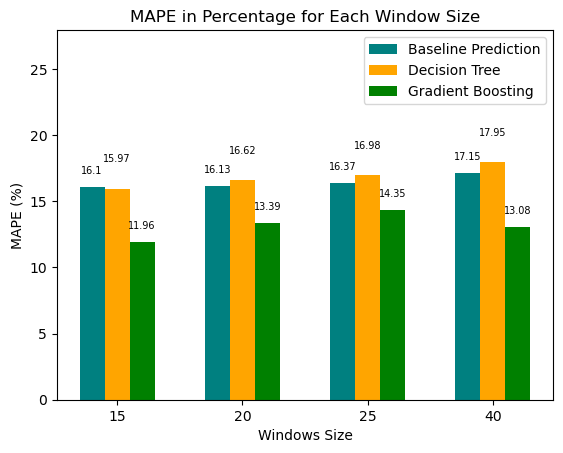

In [72]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

### Sequence of Pasts Predicts Sequence of Futures

In [73]:
df_list = get_windows_sequence(df_organic, "Large", WINDOWS)

In [74]:
l_o_X_trains = list()
l_o_y_trains = list()
l_o_X_tests = list()
l_o_y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large",0.8)
    l_o_X_trains.append(X_train)
    l_o_y_trains.append(y_train)
    l_o_X_tests.append(X_test)
    l_o_y_tests.append(y_test)


In [75]:
l_o_bp_preds = list()
l_o_bp_mapes = list()

l_o_dt_preds = list()
l_o_dt_mapes = list()

l_o_rc_preds = list()
l_o_rc_mapes = list()

for i, v in enumerate(l_o_X_trains):
    bp = bp_calc(l_o_X_tests[i], l_o_y_tests[i])
    dt = dt_calc(l_o_X_trains[i], l_o_y_trains[i], l_o_X_tests[i], l_o_y_tests[i])
    rc = rc_calc(l_o_X_trains[i], l_o_y_trains[i], l_o_X_tests[i], l_o_y_tests[i])
    l_o_bp_preds.append(bp[0])
    l_o_bp_mapes.append(bp[1])
    l_o_dt_preds.append(dt[0])
    l_o_dt_mapes.append(dt[1])
    l_o_rc_preds.append(rc[0])
    l_o_rc_mapes.append(rc[1])
    

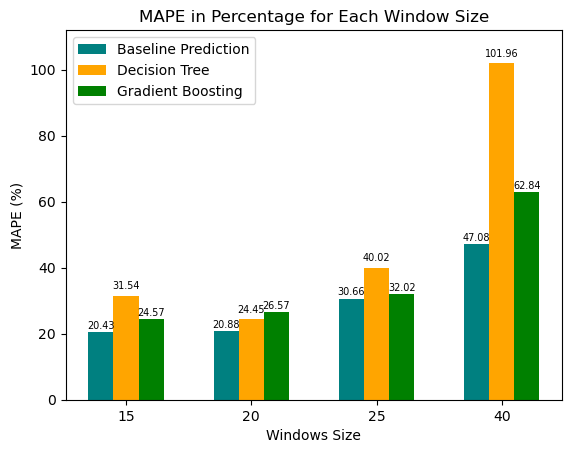

In [76]:
plot_mape_comparison(l_o_bp_mapes, l_o_dt_mapes, l_o_rc_mapes, WINDOWS)

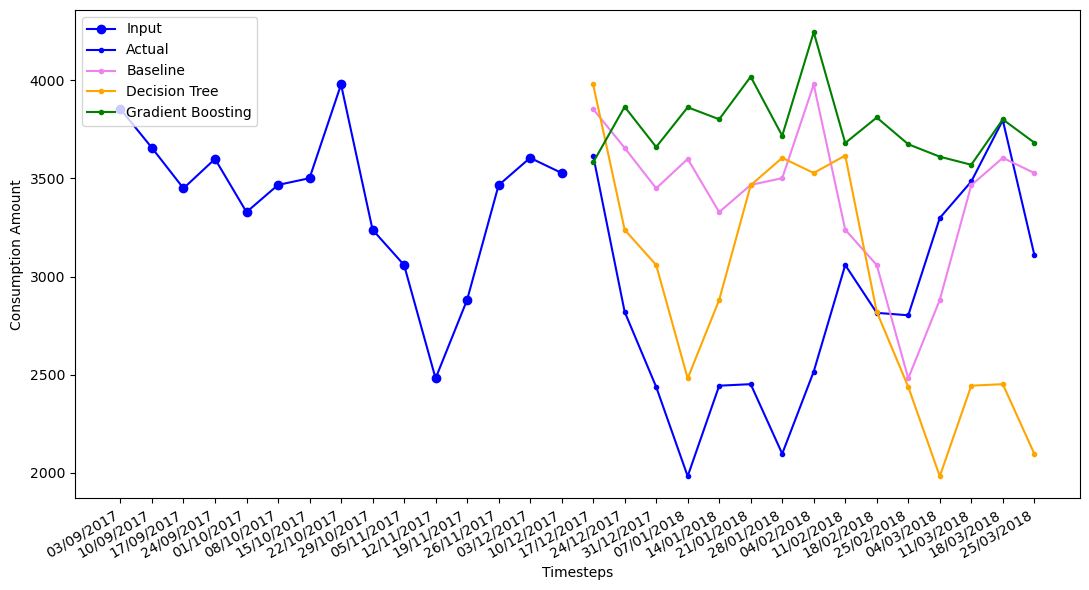

In [77]:
#สามารถใช้ค่า i เพื่อดูกราฟในแต่ละ window_size ; [15, 20, 25, 40]
i = 0
plot_line_graph(l_o_X_tests[i], l_o_y_tests[i], l_o_bp_preds[i], l_o_dt_preds[i], l_o_rc_preds[i])

---